# pyiron_workflow
## Define workflow with pyiron_workflow

In [1]:
from inspect import isfunction
import numpy as np
from pyiron_workflow import Workflow, to_function_node, as_function_node
from pyiron_workflow.api import inputs_to_dict
from python_workflow_definition.pyiron_workflow import write_workflow_json

In [2]:
from workflow import (
    calculate_qe as _calculate_qe, 
    generate_structures as _generate_structures, 
    get_bulk_structure as _get_bulk_structure, 
    plot_energy_volume_curve as _plot_energy_volume_curve,
)

In [3]:
@as_function_node("output_dict")
def get_values_from_dict(input_dict):
    return list(input_dict.values())

In [4]:
workflow_json_filename = "pyiron_workflow_qe.json"

In [5]:
calculate_qe = to_function_node("calculate_qe", _calculate_qe, "calculate_qe")
generate_structures = to_function_node("generate_structures", _generate_structures, "generate_structures")
get_bulk_structure = to_function_node("get_bulk_structure", _get_bulk_structure, "get_bulk_structure")
plot_energy_volume_curve = to_function_node("plot_energy_volume_curve", _plot_energy_volume_curve, "plot_energy_volume_curve", validate_output_labels=False)

In [6]:
wf = Workflow("my_workflow")

In [7]:
wf.pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [8]:
wf.element = "Al"
wf.a = 4.04
wf.cubic = True
wf.structure = get_bulk_structure(
    element=wf.element,
    a=wf.a,
    cubic=wf.cubic,
)

In [9]:
wf.working_directory_0 = "mini"
input_dict = {
    "structure": wf.structure, 
    "pseudopotentials": wf.pseudopotentials, 
    "kpts": (3, 3, 3), 
    "calculation": "vc-relax", 
    "smearing": 0.02,
}
wf.input_dict_0 = inputs_to_dict(
    input_specification=list(input_dict.keys()),
    **input_dict
)

In [10]:
wf.calc_mini = calculate_qe(
    working_directory=wf.working_directory_0,
    input_dict=wf.input_dict_0,
)

In [11]:
number_of_strains = 5
wf.strain_lst = np.linspace(0.9, 1.1, number_of_strains)
wf.structure_lst = generate_structures(  # the generate_structures() function is not available in the workflow graph
    structure=wf.calc_mini["structure"],
    strain_lst=wf.strain_lst,
)

In [12]:
job_strain_lst = []
for i in range(number_of_strains):
    setattr(wf, "input_dict_" + str(i+1), inputs_to_dict(
        input_specification=["structure", "pseudopotentials", "kpts", "calculation", "smearing"],
        structure=wf.structure_lst["s_" + str(i)],
        pseudopotentials=wf.pseudopotentials,
        kpts=(3, 3, 3),
        calculation="scf",
        smearing=0.02,
    ))
    setattr(wf, "calc_strain_" + str(i), calculate_qe(
        working_directory="strain_" + str(i),
        input_dict=getattr(wf, "input_dict_" + str(i+1)),
    ))
    job_strain_lst.append(getattr(wf, "calc_strain_" + str(i)))

In [13]:
volume_dict = {"s_" + str(i): j["volume"] for i, j in enumerate(job_strain_lst)}
wf.volume_dict = inputs_to_dict(
    input_specification=list(volume_dict.keys()),
    **volume_dict
)
energy_dict = {"s_" + str(i): j["energy"] for i, j in enumerate(job_strain_lst)}
wf.energy_dict = inputs_to_dict(
    input_specification=list(energy_dict.keys()),
    **energy_dict,
)
wf.volume_lst = get_values_from_dict(
    input_dict=wf.volume_dict
)
wf.energy_lst = get_values_from_dict(
    input_dict=wf.energy_dict
)

In [14]:
wf.plot = plot_energy_volume_curve(volume_lst=wf.volume_lst, energy_lst=wf.energy_lst)

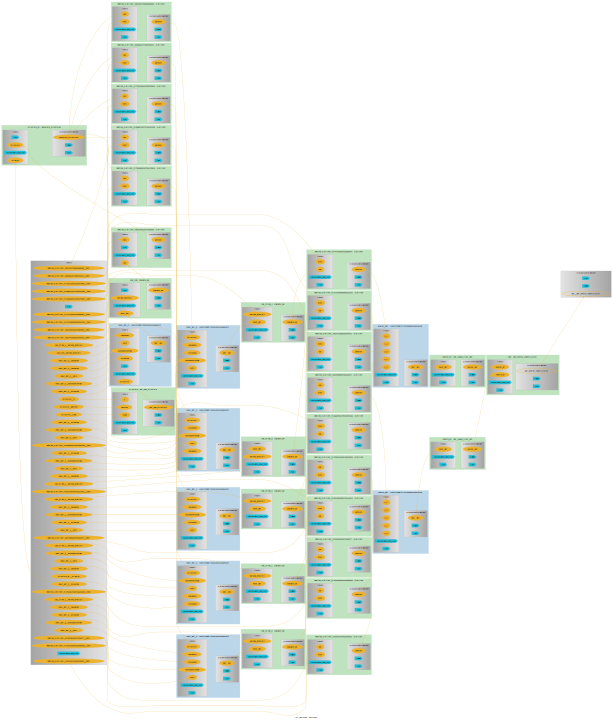

In [15]:
wf.draw(size=(10,10))

In [16]:
write_workflow_json(graph_as_dict=wf.graph_as_dict, file_name=workflow_json_filename)

In [17]:
!cat {workflow_json_filename}

{
  "version": "0.1.0",
  "nodes": [
    {
      "id": 0,
      "type": "function",
      "value": "workflow.get_bulk_structure"
    },
    {
      "id": 1,
      "type": "function",
      "value": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 2,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 3,
      "type": "function",
      "value": "workflow.generate_structures"
    },
    {
      "id": 4,
      "type": "function",
      "value": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 5,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 6,
      "type": "function",
      "value": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 7,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 8,
      "type": "function",
      "value": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 9,
      "t

## Load Workflow with aiida

In [18]:
from aiida import orm, load_profile

load_profile()

Profile<uuid='10fd2c58703f4c7697d0aa96b3624683' name='pwd'>

In [19]:
from python_workflow_definition.aiida import load_workflow_json

In [20]:
wg = load_workflow_json(file_name=workflow_json_filename)

In [ ]:
wg.nodes.get_bulk_structure.inputs.a.value = orm.Float(4.05)

05/26/2025 05:57:55 AM <86> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [17|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_bulk_structure1
05/26/2025 05:57:56 AM <86> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [17|WorkGraphEngine|update_task_state]: Task: get_bulk_structure1, type: PyFunction, finished.
05/26/2025 05:57:56 AM <86> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [17|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_dict2
05/26/2025 05:57:56 AM <86> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [17|WorkGraphEngine|update_task_state]: Task: get_dict2, type: PyFunction, finished.
05/26/2025 05:57:56 AM <86> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [17|WorkGraphEngine|continue_workgraph]: tasks ready to run: calculate_qe3
[jupyter-pythonworkflow-fl--x---35e2fba5:00217] mca_base_component_repository_open: unable to open mca_btl_openib: lib

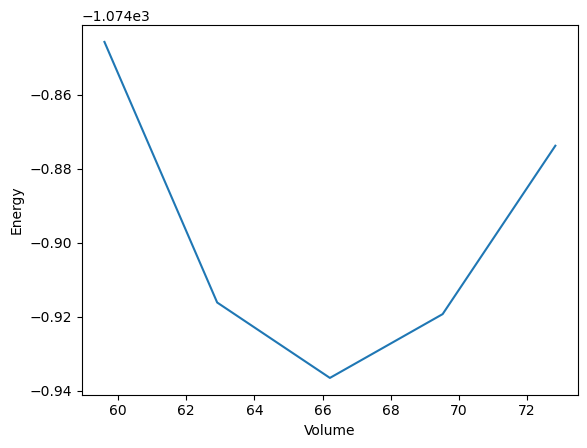

In [22]:
wg.run()

## Load Workflow with jobflow

In [23]:
from python_workflow_definition.jobflow import load_workflow_json

In [24]:
from jobflow.managers.local import run_locally

In [25]:
flow = load_workflow_json(file_name=workflow_json_filename)

In [26]:
flow[0].function_kwargs["a"] = 4.05

2025-05-26 06:00:02,662 INFO Started executing jobs locally
2025-05-26 06:00:02,768 INFO Starting job - get_bulk_structure (2521ebff-2219-4e59-9425-4f3ab2851e2a)
2025-05-26 06:00:02,771 INFO Finished job - get_bulk_structure (2521ebff-2219-4e59-9425-4f3ab2851e2a)
2025-05-26 06:00:02,772 INFO Starting job - get_dict (16a60b49-6205-418e-a640-7a128111d10c)
2025-05-26 06:00:02,776 INFO Finished job - get_dict (16a60b49-6205-418e-a640-7a128111d10c)
2025-05-26 06:00:02,777 INFO Starting job - calculate_qe (ac278a4f-b187-498e-a234-4060e13f5b06)


[jupyter-pythonworkflow-fl--x---35e2fba5:00319] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-26 06:00:53,435 INFO Finished job - calculate_qe (ac278a4f-b187-498e-a234-4060e13f5b06)
2025-05-26 06:00:53,436 INFO Starting job - generate_structures (40215563-bfe0-47dc-a31b-124b15688007)
2025-05-26 06:00:53,440 INFO Finished job - generate_structures (40215563-bfe0-47dc-a31b-124b15688007)
2025-05-26 06:00:53,440 INFO Starting job - get_dict (65b32304-10b3-4711-9f55-2dcc5c405641)
2025-05-26 06:00:53,442 INFO Finished job - get_dict (65b32304-10b3-4711-9f55-2dcc5c405641)
2025-05-26 06:00:53,442 INFO Starting job - get_dict (77f8e7d0-2281-42cc-b39e-d7acc34f5458)
2025-05-26 06:00:53,444 INFO Finished job - get_dict (77f8e7d0-2281-42cc-b39e-d7acc34f5458)
2025-05-26 06:00:53,445 INFO Starting job - get_dict (65655d5b-ccf4-44bd-8c8d-6e833b329ede)
2025-05-26 06:00:53,446 INFO Finished job - get_dict (65655d5b-ccf4-44bd-8c8d-6e833b329ede)
2025-05-26 06:00:53,447 INFO Starting job - get_dict (bc4172ef-be1c-4ad0-86c0-156181da184a)
2025-05-26 06:00:53,448 INFO Finished job - get_dict (

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---35e2fba5:00344] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-26 06:01:03,461 INFO Finished job - calculate_qe (1bae14bc-f3b4-4be4-a504-7c100cf1b54c)
2025-05-26 06:01:03,462 INFO Starting job - calculate_qe (8c6e7e3c-4acc-4434-b140-ce8c97100240)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---35e2fba5:00355] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-26 06:01:16,096 INFO Finished job - calculate_qe (8c6e7e3c-4acc-4434-b140-ce8c97100240)
2025-05-26 06:01:16,097 INFO Starting job - calculate_qe (45156baf-8ffa-4c3f-8da4-6b9121e77306)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---35e2fba5:00366] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-26 06:01:28,481 INFO Finished job - calculate_qe (45156baf-8ffa-4c3f-8da4-6b9121e77306)
2025-05-26 06:01:28,482 INFO Starting job - calculate_qe (7662120d-f6da-415a-9da8-5fbcadf166aa)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---35e2fba5:00378] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-05-26 06:01:41,772 INFO Finished job - calculate_qe (7662120d-f6da-415a-9da8-5fbcadf166aa)
2025-05-26 06:01:41,773 INFO Starting job - calculate_qe (9d38753b-3c9d-40f9-aa27-eceec701734b)


[jupyter-pythonworkflow-fl--x---35e2fba5:00389] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-26 06:01:54,979 INFO Finished job - calculate_qe (9d38753b-3c9d-40f9-aa27-eceec701734b)
2025-05-26 06:01:54,980 INFO Starting job - get_list (cd676100-1e89-4293-a77f-7ca752f228cd)
2025-05-26 06:01:54,983 INFO Finished job - get_list (cd676100-1e89-4293-a77f-7ca752f228cd)
2025-05-26 06:01:54,984 INFO Starting job - get_list (44aeb1e8-6af4-4b97-8345-fc78009db91c)
2025-05-26 06:01:54,987 INFO Finished job - get_list (44aeb1e8-6af4-4b97-8345-fc78009db91c)
2025-05-26 06:01:54,987 INFO Starting job - plot_energy_volume_curve (09bec337-1bd0-434d-a322-14b6485445bf)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-05-26 06:01:55,044 INFO Finished job - plot_energy_volume_curve (09bec337-1bd0-434d-a322-14b6485445bf)
2025-05-26 06:01:55,045 INFO Finished executing jobs locally


{'2521ebff-2219-4e59-9425-4f3ab2851e2a': {1: Response(output='{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], "nsites": 4, "species": [{"name": "Al", "chemical_symbols": ["Al"], "concentration": [1.0], "mass": null, "original_name": null, "attached": null, "nattached": null}], "species_at_sites": ["Al", "Al", "Al", "Al"], "assemblies": null, "structur

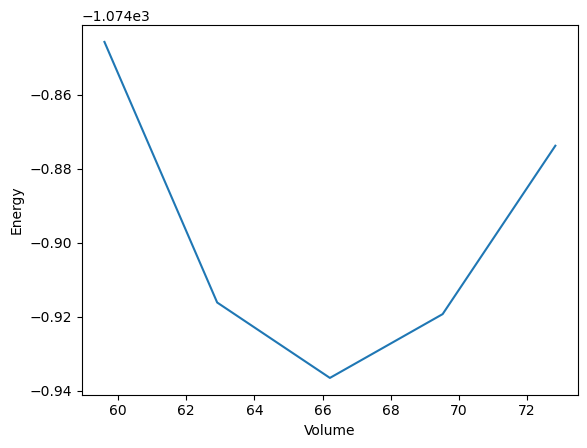

In [27]:
result = run_locally(flow)
result

## Load Workflow with pyiron_base

In [28]:
from python_workflow_definition.pyiron_base import load_workflow_json

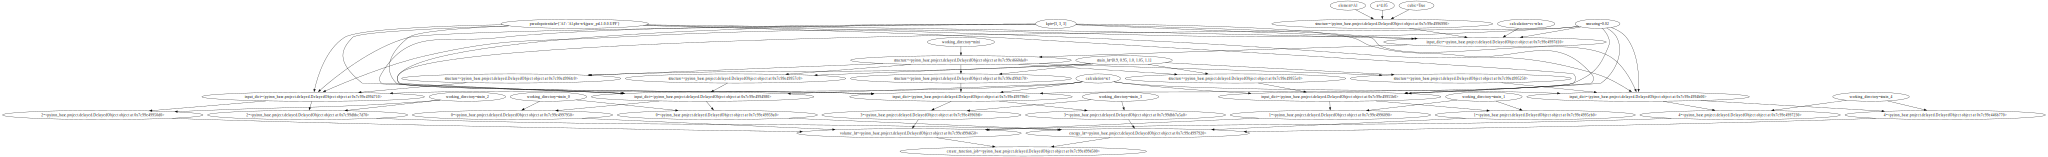

In [29]:
delayed_object_lst = load_workflow_json(file_name="workflow.json")
delayed_object_lst[-1].draw()

In [30]:
delayed_object_lst[0].input['a'] = 4.05

The job get_bulk_structure_2ca4aeae204ceaa28593c93054b07908 was saved and received the ID: 1
The job get_dict_1e47509b88d63a21fd421686554c8f4a was saved and received the ID: 2
The job calculate_qe_411e578f2700d09ba2df9a4c682b4582 was saved and received the ID: 3


[jupyter-pythonworkflow-fl--x---35e2fba5:00404] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_4d77d481fc8ea55229ec1ece04d63682 was saved and received the ID: 4
The job get_dict_83639a473c5a24b39cda4262a11ce660 was saved and received the ID: 5
The job calculate_qe_bc7507e47b3777418bec8bd6a10e8db9 was saved and received the ID: 6


[jupyter-pythonworkflow-fl--x---35e2fba5:00423] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_8911ea3b715c48fd9e6ebfd933827ad8 was saved and received the ID: 7
The job calculate_qe_3bf1743787b6db34eb1482e0cb2b49f2 was saved and received the ID: 8


[jupyter-pythonworkflow-fl--x---35e2fba5:00435] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_b30dd89506e55e06e63a020a5033af19 was saved and received the ID: 9
The job calculate_qe_7fdc96db9da025b4936748f5616be588 was saved and received the ID: 10


[jupyter-pythonworkflow-fl--x---35e2fba5:00446] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_899289e3717fb81edaca9c5c2b5d8f48 was saved and received the ID: 11
The job calculate_qe_9bb68591280fb0b90a58521fd3c6bc9d was saved and received the ID: 12


[jupyter-pythonworkflow-fl--x---35e2fba5:00457] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_12373ab37ecdba93cf91b2a4c3c016d6 was saved and received the ID: 13
The job calculate_qe_c41612cee84a2bc87674f7f0720f27af was saved and received the ID: 14


[jupyter-pythonworkflow-fl--x---35e2fba5:00468] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_4a53d87f56ee9d519ca6c738ae2cef3f was saved and received the ID: 15
The job get_list_5a5af7c495c3bd034f3904760535ba3e was saved and received the ID: 16
The job plot_energy_volume_curve_aea478ca6598efbe0596a61e39e1154d was saved and received the ID: 17


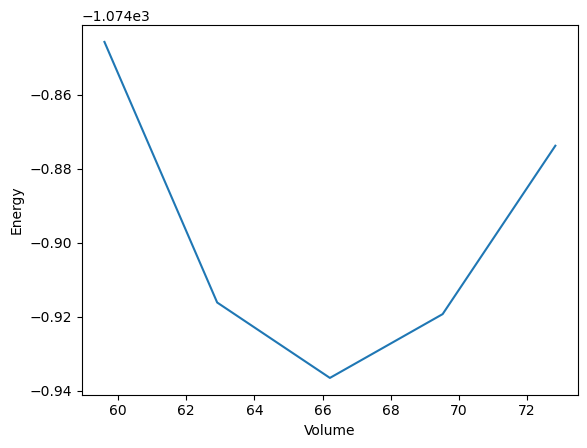

In [31]:
delayed_object_lst[-1].pull()